# Time Series Analysis I

*N. Hernitschek, 2022*

This is the eighth Jupyter notebook for **ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)**. 
This Jupyter notebook gives an introduction to time series analysis for astronomical data.

It is based on code from the textbook

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray

***Exercises required for class participation are in <font color='red'>red</font>.***


---
## Contents
* [Fourier Analysis](#first-bullet)
* [Lomb-Scargle Periodogram](#second-bullet)


### Package Installation

Please install the package `gatspy` (by Jake VanderPlas) for astronomical time-series analysis in Python. 
More information can be found at [http://www.astroml.org/gatspy/](http://www.astroml.org/gatspy/).

In [1]:
!pip3 install gatspy

     |████████████████████████████████| 554 kB 3.0 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gatspy: filename=gatspy-0.3-py3-none-any.whl size=43818 sha256=aa03feee01046c49e75bc7af6642caf3422715a981684abfee2f05f540068d6f
  Stored in directory: /Users/katiecella/Library/Caches/pip/wheels/1f/c1/4c/8de278f816259b4f67e2356c0bda260a593375661e400bf31f
Successfully built gatspy


## 1. Fourier Analysis <a class="anchor" id="first-bullet"></a>

Fourier analysis uses sines and cosines of varying harmonics of a base timescale to reconstruct any periodic function.***

The code below demonstrates the reconstruction of a signal by summation of simpler trig functions:

$$y_i(t_i) = Y_o + \sum_{m=1}^M \beta_m \sin(m \omega t_i + \phi_m)   + \epsilon_i.$$

Note: **Any** periodic function can be described within noise with a sufficiently large M! 

In the following code example, some data similar to **RR Lyrae light curves** will be decomposed using a **Fast Fourier Transform**. 

The following steps are carried out:
1. The data will be Fourier transformed.
2. You will then truncate this to only select the number of frequencies desired.
3. This truncated solution is then inverse transformed back to the time-domain to see the reconstructed model.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

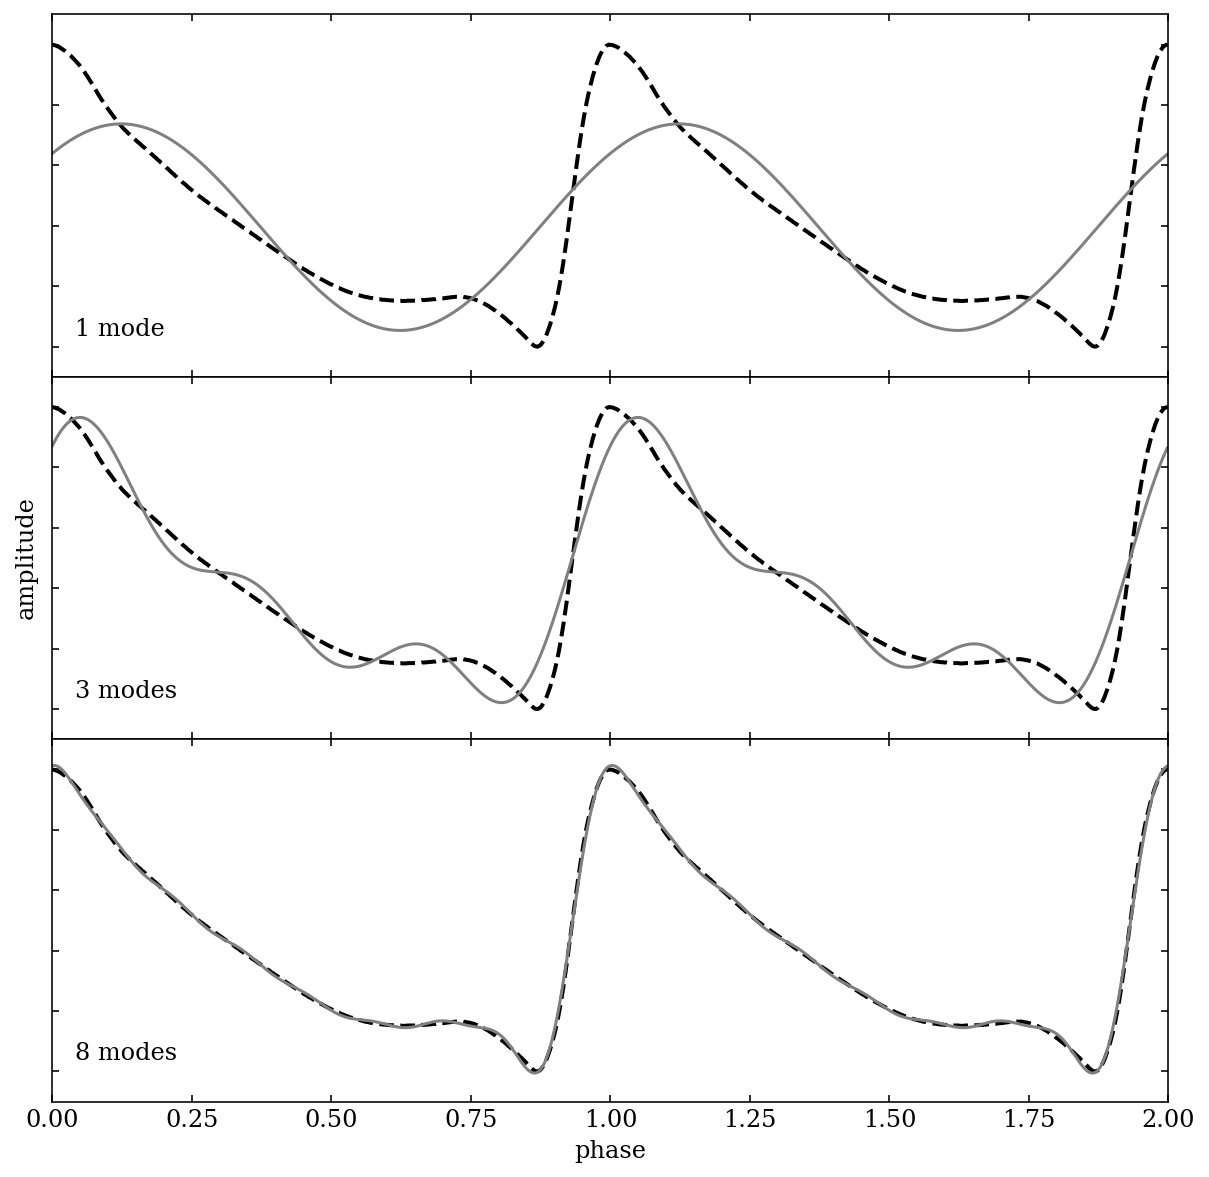

In [2]:
# Ivezic v2, Figure 10.1, edits by GTR and SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.datasets import fetch_rrlyrae_templates

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

#------------------------------------------------------------
# Load the RR Lyrae template
templates = fetch_rrlyrae_templates()
x, y = templates['115r'].T

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0)

kvals = [1, 3, 8] # number of modes/frequencies in Fourier transform
subplots = [311, 312, 313]

for (k, subplot) in zip(kvals, subplots):
    ax = fig.add_subplot(subplot)

    # Use FFT to fit a truncated Fourier series
    y_fft = np.fft.fft(y) # fourier transform data
    y_fft[k + 1:-k] = 0 # truncate to only include frequencies you want
    y_fit = np.fft.ifft(y_fft).real # inverse transform to see time-domain model

    # plot the true value and the k-term reconstruction
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y, y]), '--k', lw=2)
    ax.plot(np.concatenate([x, 1 + x]),
            np.concatenate([y_fit, y_fit]), color='gray')

    label = "%i mode" % k
    if k > 1:
        label += 's'

    ax.text(0.02, 0.1, label, ha='left', va='bottom',
            transform=ax.transAxes)

    if subplot == subplots[-1]:
        ax.set_xlabel('phase')
    else:
        ax.xaxis.set_major_formatter(plt.NullFormatter())

    if subplot == subplots[1]:
        ax.set_ylabel('amplitude')
    ax.yaxis.set_major_formatter(plt.NullFormatter())

    ax.set_xlim(0, 2)
    ax.set_ylim(1.1, -0.1)

plt.show()

The Fourier Transform can be powerful if the signal-to-noise is high, but **if the S/N is low or if the signal has a complex shape or is irregularly sampled, then a probabilistic approach is better**.  In astronomy, often the latter is the case.

## 2. Lomb-Scargle Periodogram <a class="anchor" id="second-bullet"></a>


We have seen that the periodogram is defined as

$$ P(\omega) = \frac{1}{N} \left[ \left(\sum_{j=1}^N y_j\sin(\omega t_j) \right)^2 + \left(\sum_{j=1}^N y_j\cos(\omega t_j) \right)^2 \right]$$

The "best value" $\omega$ is given by

$$\chi^2(\omega) =  \chi_0^2 \, \left[1 - {2 \over N \, V}  \, P(\omega) \right],$$

where $P(\omega)$ is the periodogram and $\chi_0^2$ is the $\chi^2$ for the null-hypothesis model with $y(t)$ = constant:

$$  \chi_0^2 = {1 \over \sigma^2} \sum_{j=1}^N y_j^2 = {N \, V \over \sigma^2}$$

We can renormalise the periodogram, defining the **Lomb-Scargle periodogram** as

$$P_{\rm LS}(\omega) = \frac{2}{N V} P(\omega),$$  where $0 \le P_{\rm LS}(\omega) \le 1$.

With this renormalization, the ratio of $\chi^2(\omega)$ ***(for the periodic model)*** 
relative to $\chi^2_0$ ***(for the pure noise model)*** is

$${\chi^2(\omega) \over \chi^2_0}=  1 - P_{LS}(\omega).$$

To determine if our source is variable or not, we first compute $P_{\rm LS}(\omega)$ and then model the odds ratio for our variability model vs. a no-variability model. If our variability model is "correct", then the peak of $P(\omega)$ [found by grid search] gives the best $\omega$.

Below is an example of a LS periodogram generated using 100 points drawn from $y(t|P) = 10 + \sin(2\pi t/P),$ with $P=0.5$.  

The documentation at [http://www.astroml.org/gatspy/periodic/lomb_scargle.html](http://www.astroml.org/gatspy/periodic/lomb_scargle.html) gives more information on astroML's implementation.

In [6]:
# Ivezic v2, Figure 10.15, edits by GTR (see UW AST324) and SRT
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
from astroML.time_series import\
    lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap
#Need to switch to this in the future
#from astropy.stats import LombScargle

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=False)

def run(N, P):
    #------------------------------------------------------------
    # Generate Data
    np.random.seed(0)
    N = N
    P = P

    t = np.random.randint(100, size=N) + 0.3 + 0.4 * np.random.random(N)
    y = 10 + np.sin(2 * np.pi * t / P)
    dy = 0.1 + 0.1 * np.random.random(N)
    y_obs = np.random.normal(y, dy)

    #------------------------------------------------------------
    # Compute periodogram
    period = 10 ** np.linspace(-1, 0, 10000)
    omega = 2 * np.pi / period
    PS = lomb_scargle(t, y_obs, dy, 
                      omega, generalized=True)

    #------------------------------------------------------------
    # Get significance via bootstrap
    D = lomb_scargle_bootstrap(t, y_obs, dy, omega, generalized=True, 
                               N_bootstraps=1000, random_state=0)
    #Need to switch to this in the future
    #D = LombScargle(t, y_obs, dy, omega, generalized=True, 
    #                N_bootstraps=1000, random_state=0)
    sig1, sig5 = np.percentile(D, [99, 99.9])

    #------------------------------------------------------------
    # Plot the results
    fig = plt.figure(figsize=(10, 5))
    fig.subplots_adjust(left=0.1, right=0.9, hspace=0.35)

    # First panel: the data
    ax = fig.add_subplot(211)
    ax.errorbar(t, y_obs, dy, fmt='.k', lw=1, ecolor='gray')
    ax.set_xlabel('time (days)')
    ax.set_ylabel('flux')
    ax.set_xlim(-5, 105)

    # Second panel: the periodogram & significance levels
    ax1 = fig.add_subplot(212, xscale='log')
    ax1.plot(period, PS, '-', 
             c='black', lw=1, zorder=1)
    ax1.plot([period[0], period[-1]], 
             [sig1, sig1], ':', c='black')
    ax1.plot([period[0], period[-1]], 
             [sig5, sig5], ':', c='black')


    ax1.set_xlim(period[0], period[-1])
    ax1.set_ylim(-0.05, 0.85)

    ax1.set_xlabel(r'period (days)')
    ax1.set_ylabel('power')

    # Twin axis: label BIC on the right side
    ax2 = ax1.twinx()
    ax2.set_ylim(tuple(lomb_scargle_BIC(ax1.get_ylim(), y_obs, dy)))
    ax2.set_ylabel(r'$\Delta BIC$')

    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_minor_formatter(plt.FormatStrFormatter('%.1f'))
    ax1.xaxis.set_major_locator(plt.LogLocator(10))
    ax1.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3g'))

    plt.show()

        Use astropy.stats.LombScargle instead. [warnings]
        Use astropy.stats.LombScargle.false_alarm_probability instead. [warnings]
        Use astropy.stats.LombScargle instead. [astroML.time_series.periodogram]


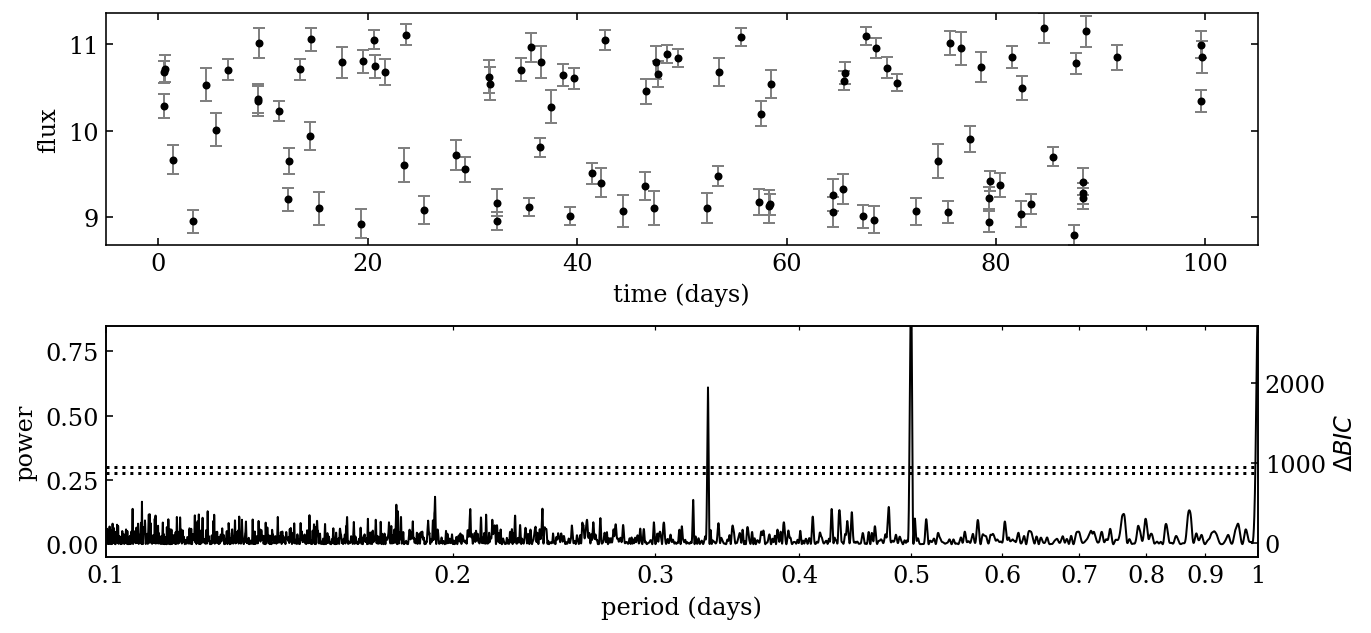

In [7]:
run(100,0.5)

        Use astropy.stats.LombScargle instead. [warnings]
        Use astropy.stats.LombScargle.false_alarm_probability instead. [warnings]
        Use astropy.stats.LombScargle instead. [astroML.time_series.periodogram]


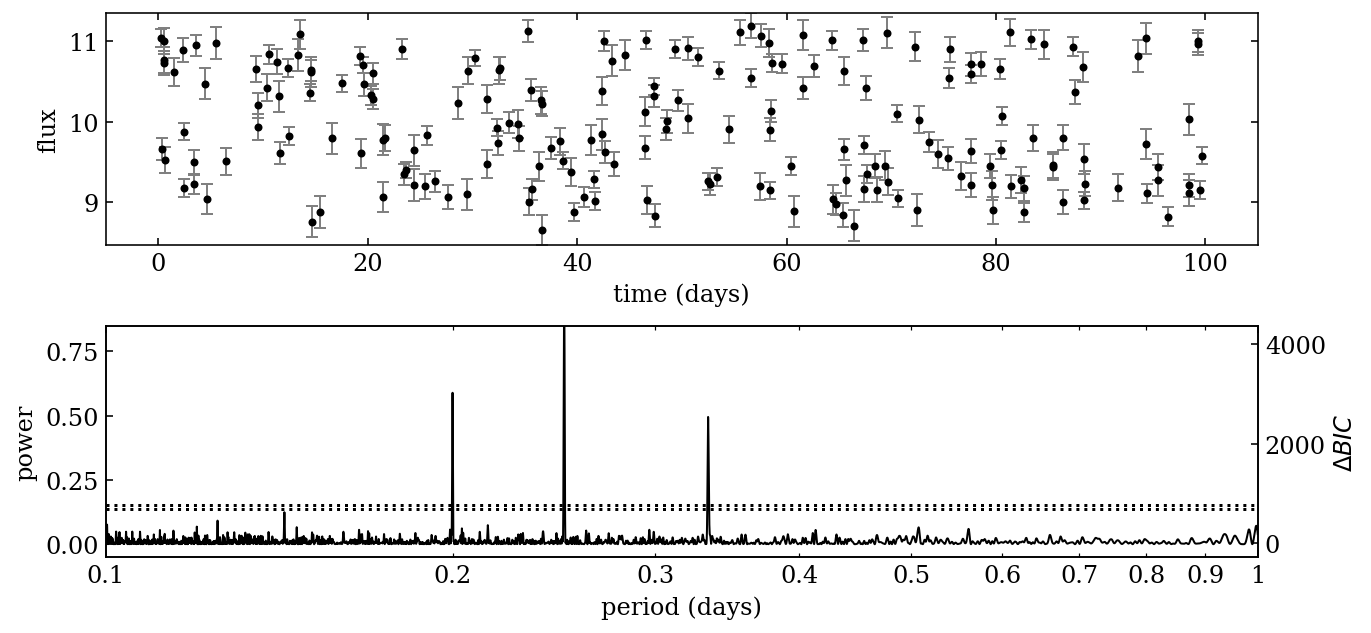

In [8]:
run(200, 0.25)


<font color='red'>Change the period and the number of points and compare your results.</font>


## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* an understanding of time series in astronomy
* seen some algorithms for extracting information from time series.